In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

_Introduction_

1. In this analysis, we will conduct a COVID-19 prediction under spatial (geographic region) and temporal (day) dimension for some interested states (New York, California, Texas and etc).

2. We are interested in exploring the relationship among confirmed cases, death cases and other features.

3. In this part, we fit an autoregression model to predict the confirmed cases and deaths cases.

__Importing Data__

In [2]:
df_covid = pd.read_csv("us_daily_processed.csv")

In [3]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184163 entries, 0 to 184162
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      184163 non-null  int64  
 1   date            184163 non-null  object 
 2   FIPS            179280 non-null  float64
 3   Admin2          183001 non-null  object 
 4   Province_State  184080 non-null  object 
 5   Country_Region  184163 non-null  object 
 6   Last_Update     184163 non-null  object 
 7   Lat             181019 non-null  float64
 8   Long_           181019 non-null  float64
 9   Confirmed       184163 non-null  int64  
 10  Deaths          184133 non-null  float64
 11  Recovered       184133 non-null  float64
 12  Active          183456 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 18.3+ MB


In [4]:
df_covid.shape

(184163, 13)

In [5]:
n1=df_covid.shape[0]
datelist=[]
statelist=[]
for i in range(n1):
    if (df_covid["date"][i] not in datelist):
        datelist.append(df_covid["date"][i])
    if (df_covid["Province_State"][i] not in statelist):
        statelist.append(df_covid["Province_State"][i])
print(datelist)
print(statelist)

['01-22-2020', '01-23-2020', '01-24-2020', '01-25-2020', '01-26-2020', '01-27-2020', '01-28-2020', '01-29-2020', '01-30-2020', '01-31-2020', '02-24-2020', '02-25-2020', '02-26-2020', '02-27-2020', '02-28-2020', '02-29-2020', '03-01-2020', '03-02-2020', '03-03-2020', '03-04-2020', '03-05-2020', '03-06-2020', '03-07-2020', '03-08-2020', '03-09-2020', '03-10-2020', '03-11-2020', '03-12-2020', '03-13-2020', '03-14-2020', '03-15-2020', '03-16-2020', '03-17-2020', '03-18-2020', '03-19-2020', '03-20-2020', '03-21-2020', '03-22-2020', '03-23-2020', '03-24-2020', '03-25-2020', '03-26-2020', '03-27-2020', '03-28-2020', '03-29-2020', '03-30-2020', '03-31-2020', '04-01-2020', '04-02-2020', '04-03-2020', '04-04-2020', '04-05-2020', '04-06-2020', '04-07-2020', '04-08-2020', '04-09-2020', '04-10-2020', '04-11-2020', '04-12-2020', '04-13-2020', '04-14-2020', '04-15-2020', '04-16-2020', '04-17-2020', '04-18-2020', '04-19-2020', '04-20-2020', '04-21-2020', '04-22-2020', '04-23-2020', '04-24-2020', '04-2

In [6]:
us_state_date_confirmed = df_covid.groupby(['Province_State','date'])['Confirmed'].sum().reset_index()
us_state_date_death = df_covid.groupby(['Province_State','date'])['Deaths'].sum().reset_index()
df_confirmed_bystate = pd.DataFrame(us_state_date_confirmed)
df_death_bystate = pd.DataFrame(us_state_date_death)

In [7]:
df_temp= pd.read_csv("COVID_19_us_temp.csv")

In [8]:
df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

,date,Max,Avg,Min,Province_State,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
0,2020-02-01,56,49.2,42,Alabama,0.0,0.0,0.0,0.0,0,0,0
1,2020-02-01,30,28.7,26,Alaska,0.0,0.0,0.0,0.0,0,0,0
2,2020-02-01,78,61.4,47,Arizona,0.0,0.0,0.0,0.0,0,0,0
3,2020-02-01,58,46.6,36,Arkansas,0.0,0.0,0.0,0.0,0,0,0
4,2020-02-01,64,49.1,42,California,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5695,2020-05-24,87,77.1,69,Tennessee,20111.0,336.0,0.0,19775.0,326,7,0
5696,2020-05-24,66,57.7,53,South Dakota,4563.0,50.0,0.0,4513.0,99,0,0
5697,2020-05-24,90,78.3,68,South Carolina,10096.0,435.0,0.0,9661.0,201,10,0
5698,2020-05-24,66,55.3,46,Rhode Island,14065.0,608.0,0.0,13457.0,113,11,0


In [9]:
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)
df_temp_bystate

,Province_State,date,Avg,Confirmed,Deaths
0,Arkansas,2020-02-01,46.6,0.0,0.0
1,Arkansas,2020-02-02,55.5,0.0,0.0
2,Arkansas,2020-02-03,61.0,0.0,0.0
3,Arkansas,2020-02-04,58.7,0.0,0.0
4,Arkansas,2020-02-05,40.3,0.0,0.0
...,...,...,...,...,...
5695,Wyoming,2020-05-20,65.1,787.0,11.0
5696,Wyoming,2020-05-21,56.3,801.0,12.0
5697,Wyoming,2020-05-22,60.8,803.0,12.0
5698,Wyoming,2020-05-23,57.7,813.0,12.0


_Part II. ARIMA Process model fitting for individual states_

In this part, we are using ARIMA process

In [16]:
def ARIMA_covid_confirmed(state,p,d,q):
    df_confirmed_s=df_confirmed_bystate.loc[df_confirmed_bystate['Province_State'] == state]
    series = df_confirmed_s['Confirmed']
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series.values
    
    plot_acf(y)
    plt.show()
    plot_pacf(y)
    plt.show()
    
    ts_df=pd.DataFrame(y,columns=['Confirmed'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Confirmed']
    ts_test = ts_df.iloc[n_train:]['Confirmed']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q),)
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    print(model_fit.summary())
    
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals)
    plt.show()
    
    model_fit.plot_predict(dynamic=False)
    plt.title('In Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Cases')
    plt.title('Out of Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.legend()
    plt.show()  

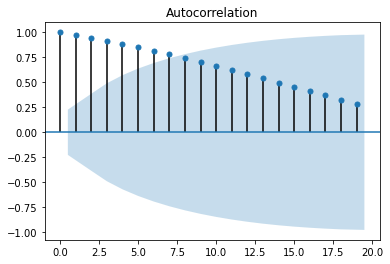

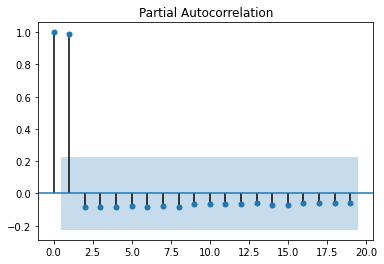

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -539.140
Method:                       css-mle   S.D. of innovations           1914.243
Date:                Sat, 06 Jun 2020   AIC                           1084.280
Time:                        15:10:29   BIC                           1090.563
Sample:                             1   HQIC                          1086.737
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4973.8391   1362.257      3.651      0.000    2303.864    7643.814
ar.L1.D.y      0.8282      0.073     11.312      0.000       0.685       0.972
                                    Roots           

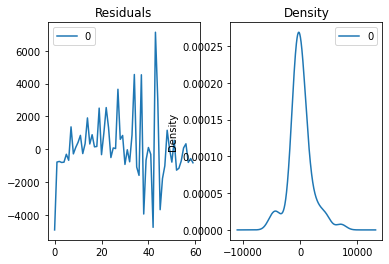

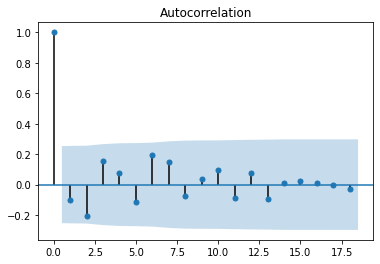

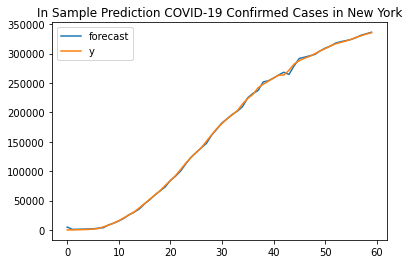

predicted=338132.000000, expected=337055.000000
predicted=341253.000000, expected=338485.000000
predicted=344693.000000, expected=340661.000000
predicted=348396.000000, expected=343051.000000
predicted=352318.000000, expected=345813.000000
predicted=356421.000000, expected=348232.000000
predicted=360673.000000, expected=350121.000000
predicted=365049.000000, expected=351371.000000
predicted=369528.000000, expected=352845.000000
predicted=374092.000000, expected=354370.000000
predicted=378727.000000, expected=356458.000000
predicted=383420.000000, expected=358154.000000
predicted=388161.000000, expected=359926.000000
predicted=392942.000000, expected=361515.000000


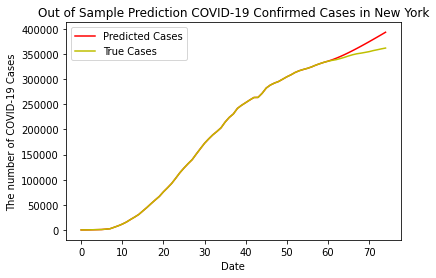

In [17]:
ARIMA_covid_confirmed('New York',1,1,0)

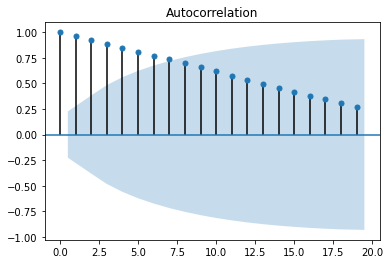

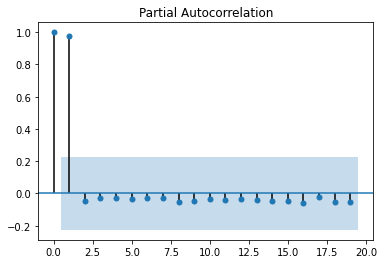

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -456.275
Method:                       css-mle   S.D. of innovations            481.298
Date:                Sat, 06 Jun 2020   AIC                            920.550
Time:                        15:10:33   BIC                            928.927
Sample:                             1   HQIC                           923.827
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1075.0611    307.430      3.497      0.000     472.510    1677.613
ar.L1.D.y      0.3132      0.116      2.695      0.007       0.085       0.541
ar.L2.D.y      0.5047      0.124      4.068      0.0

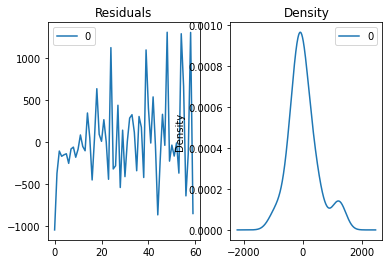

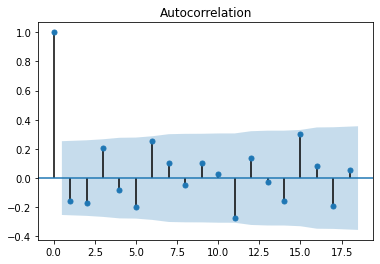

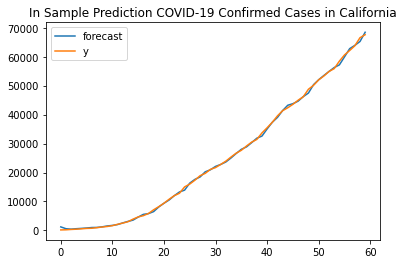

predicted=69524.000000, expected=69329.000000
predicted=70849.000000, expected=70978.000000
predicted=72431.000000, expected=72798.000000
predicted=73791.000000, expected=74871.000000
predicted=75211.000000, expected=76693.000000
predicted=76538.000000, expected=78725.000000
predicted=77866.000000, expected=80166.000000
predicted=79147.000000, expected=81457.000000
predicted=80415.000000, expected=83752.000000
predicted=81654.000000, expected=85997.000000
predicted=82878.000000, expected=88031.000000
predicted=84082.000000, expected=90252.000000
predicted=85273.000000, expected=92539.000000
predicted=86450.000000, expected=94020.000000


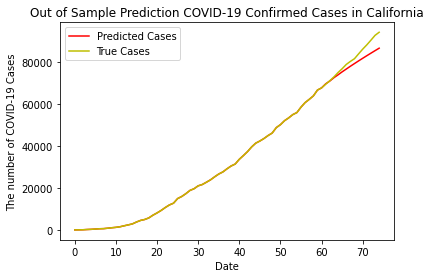

In [18]:
ARIMA_covid_confirmed('California',2,1,0)

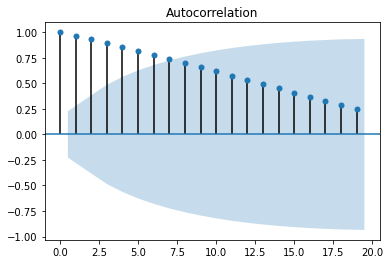

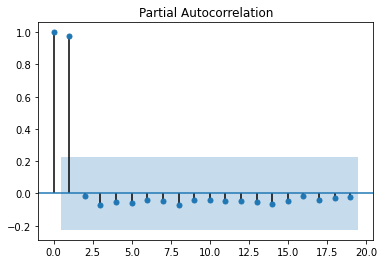

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -385.589
Method:                       css-mle   S.D. of innovations            148.983
Date:                Sat, 06 Jun 2020   AIC                            779.178
Time:                        15:10:54   BIC                            787.555
Sample:                             1   HQIC                           782.454
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        269.3613     43.203      6.235      0.000     184.686     354.037
ar.L1.D.y      0.1577      0.116      1.363      0.173      -0.069       0.385
ar.L2.D.y      0.4112      0.117      3.522      0.0

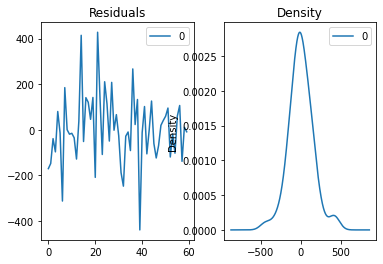

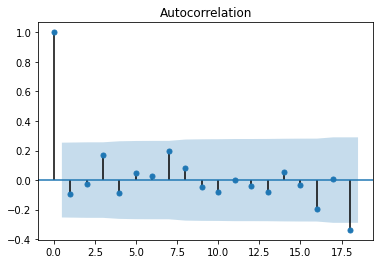

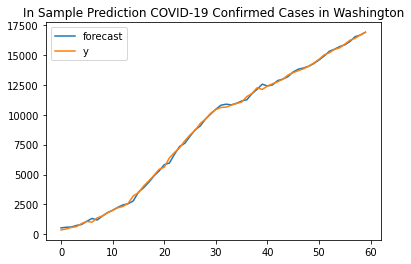

predicted=17158.000000, expected=17122.000000
predicted=17406.000000, expected=17330.000000
predicted=17671.000000, expected=17512.000000
predicted=17931.000000, expected=17773.000000
predicted=18197.000000, expected=17951.000000
predicted=18462.000000, expected=18288.000000
predicted=18730.000000, expected=18433.000000
predicted=18997.000000, expected=18611.000000
predicted=19265.000000, expected=18811.000000
predicted=19533.000000, expected=18971.000000
predicted=19802.000000, expected=19117.000000
predicted=20071.000000, expected=19265.000000
predicted=20340.000000, expected=19265.000000
predicted=20609.000000, expected=19828.000000


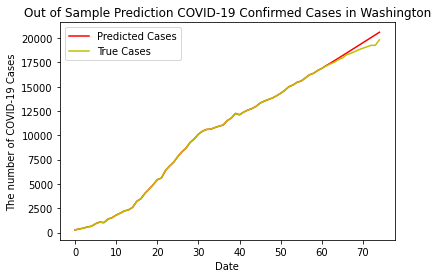

In [19]:
ARIMA_covid_confirmed('Washington',2,1,0)

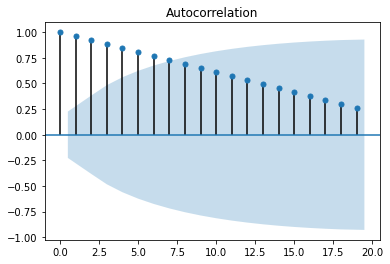

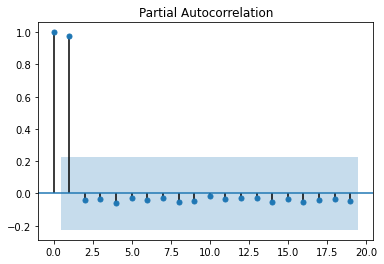

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -408.721
Method:                       css-mle   S.D. of innovations            217.073
Date:                Sat, 06 Jun 2020   AIC                            825.442
Time:                        15:11:01   BIC                            833.819
Sample:                             1   HQIC                           828.719
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        601.4076    233.052      2.581      0.010     144.634    1058.181
ar.L1.D.y      0.4667      0.115      4.063      0.000       0.242       0.692
ar.L2.D.y      0.4324      0.118      3.659      0.0

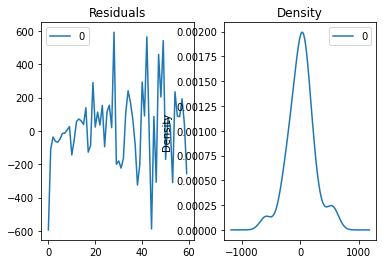

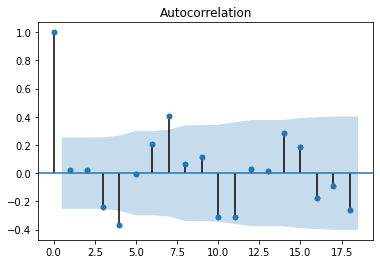

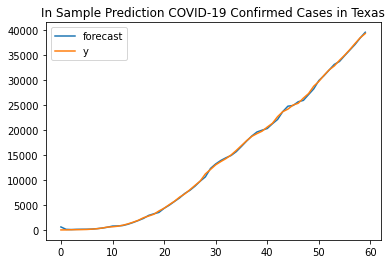

predicted=40218.000000, expected=40555.000000
predicted=41100.000000, expected=41432.000000
predicted=41988.000000, expected=43020.000000
predicted=42845.000000, expected=44480.000000
predicted=43689.000000, expected=45721.000000
predicted=44514.000000, expected=47452.000000
predicted=45325.000000, expected=48396.000000
predicted=46121.000000, expected=49177.000000
predicted=46903.000000, expected=50552.000000
predicted=47673.000000, expected=51673.000000
predicted=48432.000000, expected=53053.000000
predicted=49180.000000, expected=53539.000000
predicted=49917.000000, expected=54776.000000
predicted=50645.000000, expected=55861.000000


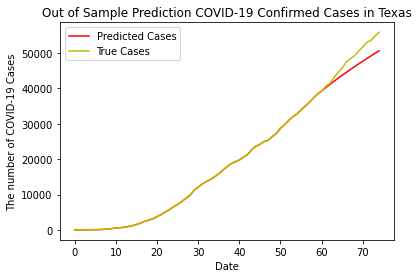

In [20]:
ARIMA_covid_confirmed('Texas',2,1,0)

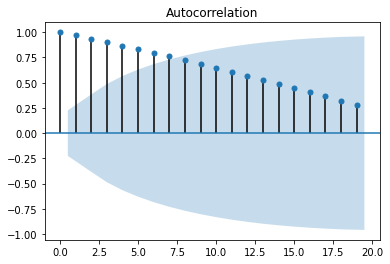

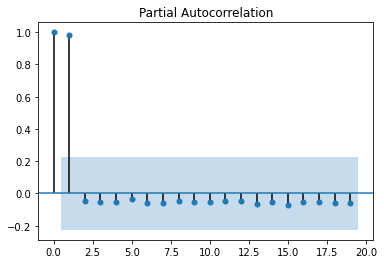

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -430.929
Method:                       css-mle   S.D. of innovations            315.121
Date:                Sat, 06 Jun 2020   AIC                            871.857
Time:                        15:11:16   BIC                            882.329
Sample:                             1   HQIC                           875.953
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        535.0486    266.697      2.006      0.045      12.333    1057.764
ar.L1.D.y      0.6752      0.156      4.325      0.000       0.369       0.981
ar.L2.D.y      0.2703      0.143      1.884      0.0

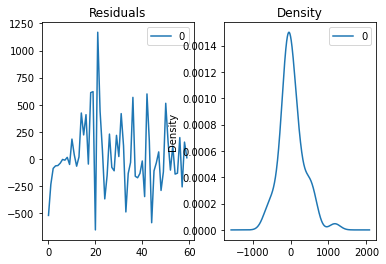

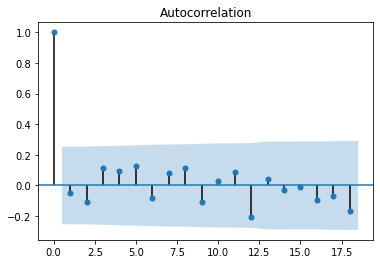

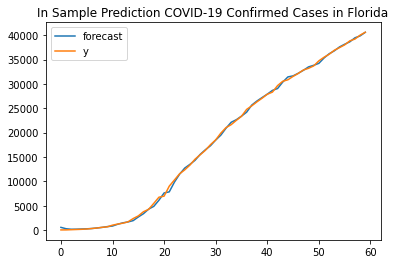

predicted=41237.000000, expected=40982.000000
predicted=41861.000000, expected=41923.000000
predicted=42484.000000, expected=42402.000000
predicted=43103.000000, expected=43210.000000
predicted=43718.000000, expected=44138.000000
predicted=44330.000000, expected=44811.000000
predicted=44939.000000, expected=45588.000000
predicted=45545.000000, expected=46442.000000
predicted=46147.000000, expected=46944.000000
predicted=46747.000000, expected=47471.000000
predicted=47344.000000, expected=48675.000000
predicted=47938.000000, expected=49451.000000
predicted=48530.000000, expected=50127.000000
predicted=49119.000000, expected=50867.000000


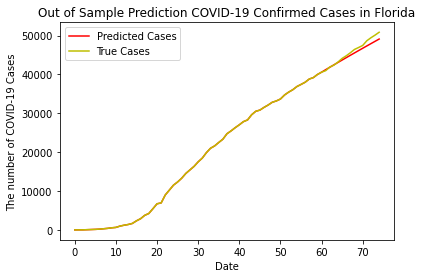

In [21]:
ARIMA_covid_confirmed('Florida',2,1,1)

In [22]:
def ARIMA_covid_death(state,p,d,q):
    df_death_s=df_death_bystate.loc[df_death_bystate['Province_State'] == state]
    series = df_death_s['Deaths']
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series.values
    
    plot_acf(y)
    plt.show()
    plot_pacf(y)
    plt.show()
    
    ts_df=pd.DataFrame(y,columns=['Deaths'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Deaths']
    ts_test = ts_df.iloc[n_train:]['Deaths']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q))
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    print(model_fit.summary())
    
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals)
    plt.show()
    
    model_fit.plot_predict(dynamic=False)
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Deaths Cases')
    plt.title('Out of Sample Prediction COVID-19 Death Cases in '+state)
    plt.legend()
    plt.show()  

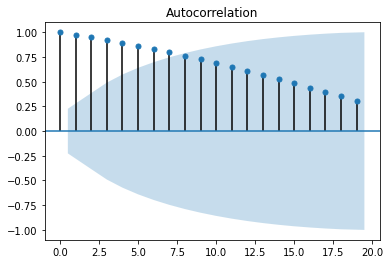

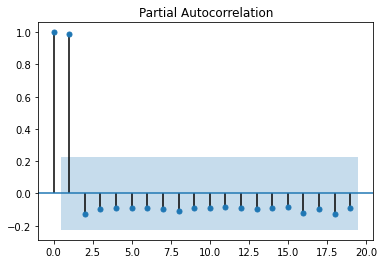

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -450.157
Method:                       css-mle   S.D. of innovations            437.201
Date:                Sat, 06 Jun 2020   AIC                            906.315
Time:                        15:12:06   BIC                            912.598
Sample:                             1   HQIC                           908.772
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        425.7780    129.020      3.300      0.001     172.903     678.653
ar.L1.D.y      0.5712      0.105      5.433      0.000       0.365       0.777
                                    Roots           

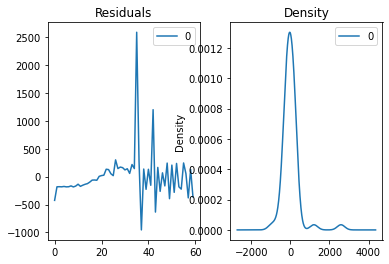

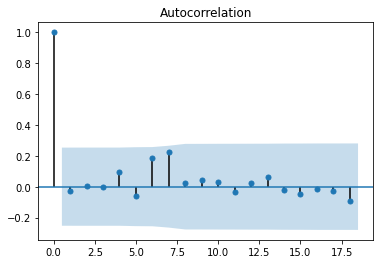

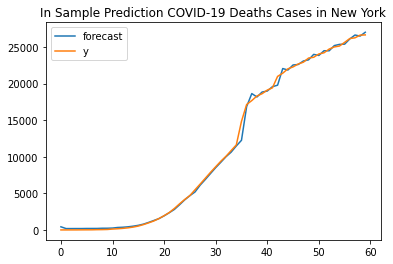

predicted=26840.000000, expected=26988.000000
predicted=27136.000000, expected=27284.000000
predicted=27488.000000, expected=27477.000000
predicted=27871.000000, expected=27641.000000
predicted=28273.000000, expected=27878.000000
predicted=28685.000000, expected=28049.000000
predicted=29103.000000, expected=28232.000000
predicted=29524.000000, expected=28339.000000
predicted=29947.000000, expected=28558.000000
predicted=30372.000000, expected=28636.000000
predicted=30797.000000, expected=28743.000000
predicted=31222.000000, expected=28853.000000
predicted=31647.000000, expected=29031.000000
predicted=32073.000000, expected=29141.000000


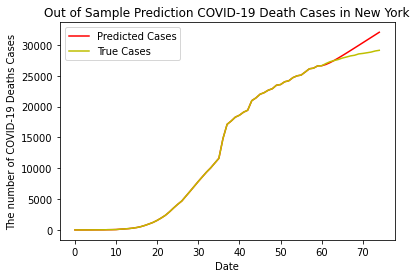

In [23]:
ARIMA_covid_death('New York',1,1,0)

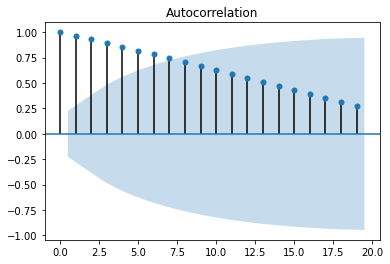

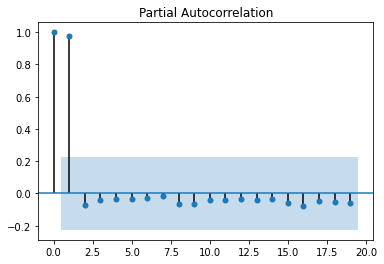

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -269.558
Method:                       css-mle   S.D. of innovations             21.450
Date:                Sat, 06 Jun 2020   AIC                            545.115
Time:                        15:12:17   BIC                            551.398
Sample:                             1   HQIC                           547.573
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9574     12.223      3.433      0.001      18.001      65.913
ar.L1.D.y      0.7847      0.078     10.015      0.000       0.631       0.938
                                    Roots           

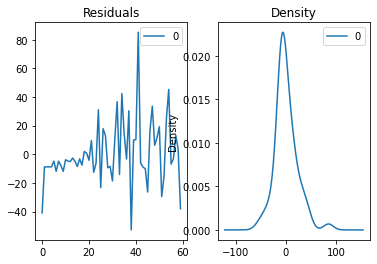

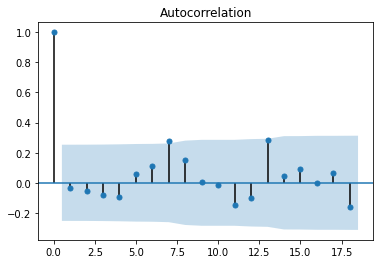

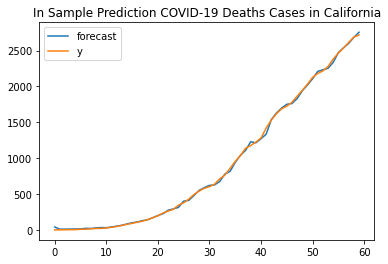

predicted=2747.000000, expected=2779.000000
predicted=2781.000000, expected=2879.000000
predicted=2817.000000, expected=2957.000000
predicted=2854.000000, expected=3052.000000
predicted=2892.000000, expected=3136.000000
predicted=2931.000000, expected=3208.000000
predicted=2971.000000, expected=3240.000000
predicted=3011.000000, expected=3279.000000
predicted=3051.000000, expected=3403.000000
predicted=3092.000000, expected=3497.000000
predicted=3133.000000, expected=3583.000000
predicted=3174.000000, expected=3666.000000
predicted=3216.000000, expected=3738.000000
predicted=3257.000000, expected=3754.000000


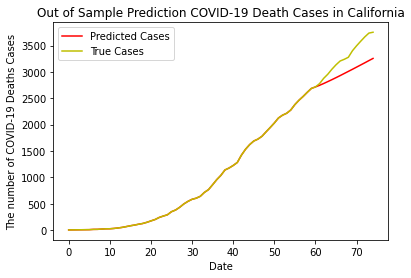

In [24]:
ARIMA_covid_death('California',1,1,0)

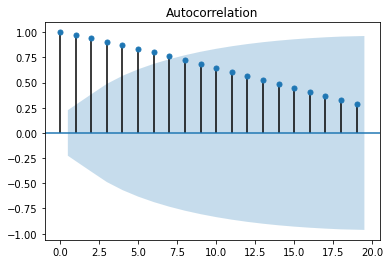

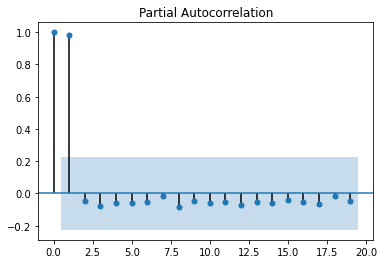

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -210.756
Method:                       css-mle   S.D. of innovations              8.087
Date:                Sat, 06 Jun 2020   AIC                            429.512
Time:                        15:12:24   BIC                            437.890
Sample:                             1   HQIC                           432.789
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9550      3.266      4.273      0.000       7.553      20.356
ar.L1.D.y      0.9080      0.087     10.438      0.000       0.738       1.079
ma.L1.D.y     -0.6962      0.133     -5.238      0.0

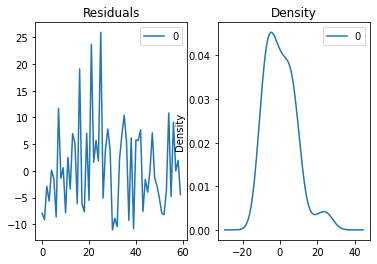

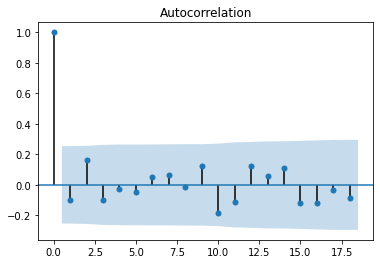

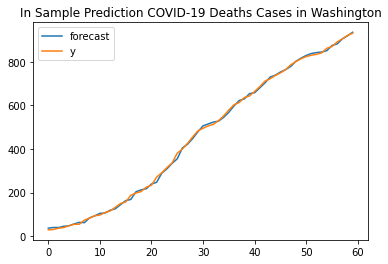

predicted=944.000000, expected=945.000000
predicted=957.000000, expected=962.000000
predicted=971.000000, expected=974.000000
predicted=985.000000, expected=983.000000
predicted=998.000000, expected=991.000000
predicted=1012.000000, expected=999.000000
predicted=1025.000000, expected=1001.000000
predicted=1039.000000, expected=1002.000000
predicted=1053.000000, expected=1031.000000
predicted=1067.000000, expected=1037.000000
predicted=1080.000000, expected=1044.000000
predicted=1094.000000, expected=1050.000000
predicted=1108.000000, expected=1050.000000
predicted=1122.000000, expected=1061.000000


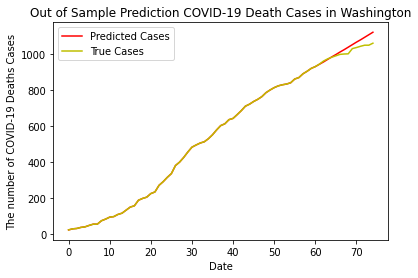

In [25]:
ARIMA_covid_death('Washington',1,1,1)

After the presentation, we will explore the time series for the temperature in each state and try to include these features into our ARIMA models. We can ot make causal statements on the relationship betwen temperatures and COVID-19 cases due to the limited data size. However, if including this feature will improve our prediction significantly, we wil use this feature.

In [26]:
def select_data(state):
    df1=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    return df1

In [27]:
def ARIMA_with_temp(state,p1,d1,q1,p2,d2,q2,p3,d3,q3):
    ts_tot=select_data(state)
    n_sample = ts_tot.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    ts_confirmed = ts_tot['Confirmed']
    ts_deaths = ts_tot['Deaths']
    ts_tempe = ts_tot['Avg']

    ts_confirmed = pd.DataFrame(ts_confirmed)
    ts_deaths = pd.DataFrame(ts_deaths)
    ts_tempe = pd.DataFrame(ts_tempe)
    
    ts_train_c = ts_confirmed.iloc[:n_train]['Confirmed']
    ts_test_c = ts_confirmed.iloc[n_train:]['Confirmed']

    ts_train_d = ts_deaths.iloc[:n_train]['Deaths']
    ts_test_d = ts_deaths.iloc[n_train:]['Deaths']

    ts_train_t = ts_tempe.iloc[:n_train]['Avg']
    ts_test_t = ts_tempe.iloc[n_train:]['Avg']
    
    ts1=ts_tot['Avg']
    ts2=ts_tot['Confirmed']
    ts_exg = pd.concat([ts1, ts2], axis=1, sort=False)
    ts_exg_np=np.array(ts_exg)
    ts_exg_train=ts_exg_np[:n_train]
    ts_exg_test=ts_exg_np[n_train:]
    
    print("Results for Confirmed Cases")
    model1=ARIMA(endog=ts_train_c,order=(p1,d1,q1),exog=ts_train_t)
    model1_fit = model1.fit(disp=0)
    predictions1 = model1_fit.forecast(steps=len(ts_test_c),exog=ts_test_t)[0]
    print(model1_fit.summary())

    residuals1 = pd.DataFrame(model1_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals1.plot(title="Residuals", ax=ax[0])
    residuals1.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals1)
    plt.show()
    
    model1_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.show()
    
    ts_test_c_np=np.array(ts_test_c)
    ts_train_c_np=np.array(ts_train_c)
    
    for i in range(len(ts_test_c)):
        print('predicted=%f, expected=%f' % (int(predictions1[i]), int(ts_test_c_np[i])))
    ts_pred_c=[]
    ts_true_c=[]
    for i in range(len(ts_train_c)):
        t2=ts_train_c_np[i]
        ts_pred_c.append(int(t2))
        ts_true_c.append(int(t2))
    for i in range(len(ts_test_c)):
        t2=predictions1[i]
        ts_pred_c.append(int(t2))
        ts_true_c.append(int(ts_test_c_np[i]))
        
    plt.plot(ts_pred_c,'r',label='Predicted Cases')
    plt.plot(ts_true_c,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.legend()
    plt.show()  
    
    print("Results for Deaths Cases")
    
    model2=ARIMA(endog=ts_train_d,order=(p2,d2,q2),exog=ts_train_t)
    model2_fit = model2.fit(disp=0)
    predictions2 = model2_fit.forecast(steps=len(ts_test_d),exog=ts_test_t)[0]
    print(model2_fit.summary())

    residuals2 = pd.DataFrame(model2_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals2.plot(title="Residuals", ax=ax[0])
    residuals2.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals2)
    plt.show()
    
    model2_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    ts_test_d_np=np.array(ts_test_d)
    ts_train_d_np=np.array(ts_train_d)
    
    for i in range(len(ts_test_d)):
        print('predicted=%f, expected=%f' % (int(predictions2[i]), int(ts_test_d_np[i])))
    ts_pred_d=[]
    ts_true_d=[]
    for i in range(len(ts_train_d)):
        t2=ts_train_d_np[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(t2))
    for i in range(len(ts_test_d)):
        t2=predictions2[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(ts_test_d_np[i]))
        
    plt.plot(ts_pred_d,'r',label='Predicted Cases')
    plt.plot(ts_true_d,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.legend()
    plt.show()  
    
    print("Using Confirmed cases and temperature as features to predict death cases")
    
    model3=ARIMA(endog=ts_train_d,order=(p3,d3,q3),exog=ts_exg_train)
    model3_fit = model3.fit(disp=0)
    predictions3 = model3_fit.forecast(steps=len(ts_test_d),exog=ts_exg_test)[0]
    print(model3_fit.summary())
    
    residuals3 = pd.DataFrame(model3_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals3.plot(title="Residuals", ax=ax[0])
    residuals3.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals3)
    plt.show()
    
    model3_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test_d)):
        print('predicted=%f, expected=%f' % (int(predictions3[i]), int(ts_test_d_np[i])))
    ts_pred_dc=[]
    ts_true_dc=[]
    for i in range(len(ts_train_d)):
        t2=ts_train_d_np[i]
        ts_pred_dc.append(int(t2))
        ts_true_dc.append(int(t2))
    for i in range(len(ts_test_d)):
        t2=predictions3[i]
        ts_pred_dc.append(int(t2))
        ts_true_dc.append(int(ts_test_d_np[i]))
        
    plt.plot(ts_pred_dc,'r',label='Predicted Cases')
    plt.plot(ts_true_dc,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.legend()
    plt.show()  

Results for Confirmed Cases
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -649.759
Method:                       css-mle   S.D. of innovations            301.418
Date:                Sat, 06 Jun 2020   AIC                           1311.519
Time:                        15:13:33   BIC                           1326.584
Sample:                             1   HQIC                          1317.596
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               525.0416    658.262      0.798      0.425    -765.127    1815.211
Avg                   2.6836      7.702      0.348      0.728     -12.412      17.

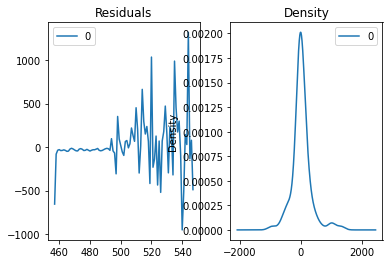

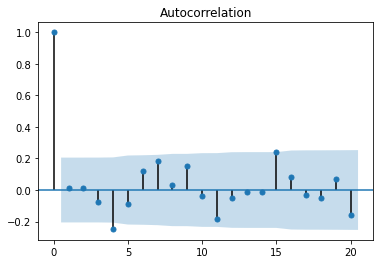

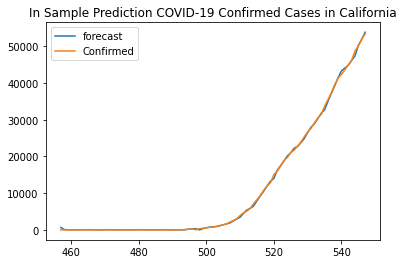

predicted=54905.000000, expected=54903.000000
predicted=56423.000000, expected=55884.000000
predicted=57873.000000, expected=58456.000000
predicted=59359.000000, expected=60616.000000
predicted=60822.000000, expected=62148.000000
predicted=62273.000000, expected=63779.000000
predicted=63707.000000, expected=66558.000000
predicted=65098.000000, expected=67600.000000
predicted=66468.000000, expected=69329.000000
predicted=67821.000000, expected=70978.000000
predicted=69155.000000, expected=72798.000000
predicted=70482.000000, expected=74871.000000
predicted=71804.000000, expected=76693.000000
predicted=73120.000000, expected=78725.000000
predicted=74412.000000, expected=80166.000000
predicted=75682.000000, expected=81457.000000
predicted=76938.000000, expected=83752.000000
predicted=78191.000000, expected=85997.000000
predicted=79445.000000, expected=88031.000000
predicted=80679.000000, expected=90252.000000
predicted=81912.000000, expected=92539.000000
predicted=83143.000000, expected=9

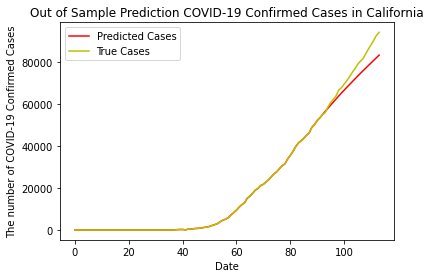

Results for Deaths Cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -380.286
Method:                       css-mle   S.D. of innovations             15.704
Date:                Sat, 06 Jun 2020   AIC                            768.573
Time:                        15:13:34   BIC                            778.616
Sample:                             1   HQIC                           772.624
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -57.0163     33.790     -1.687      0.092    -123.244       9.212
Avg                1.4569      0.585      2.490      0.013       0.310       2.604
ar.L1.D.Dea

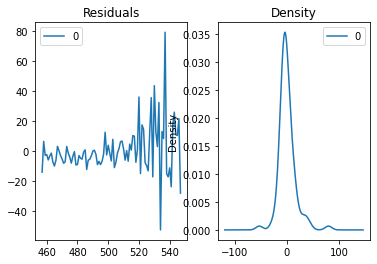

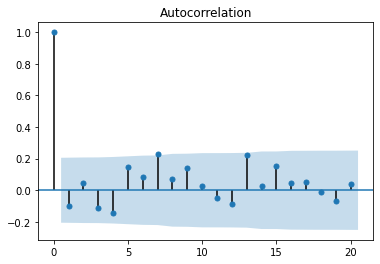

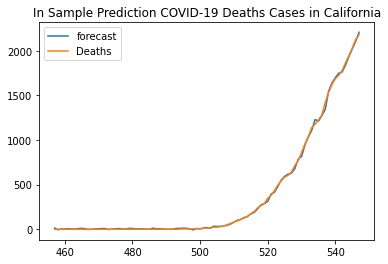

predicted=2229.000000, expected=2216.000000
predicted=2279.000000, expected=2278.000000
predicted=2331.000000, expected=2381.000000
predicted=2381.000000, expected=2464.000000
predicted=2439.000000, expected=2535.000000
predicted=2497.000000, expected=2613.000000
predicted=2551.000000, expected=2687.000000
predicted=2591.000000, expected=2716.000000
predicted=2627.000000, expected=2779.000000
predicted=2661.000000, expected=2879.000000
predicted=2693.000000, expected=2957.000000
predicted=2728.000000, expected=3052.000000
predicted=2768.000000, expected=3136.000000
predicted=2811.000000, expected=3208.000000
predicted=2849.000000, expected=3240.000000
predicted=2882.000000, expected=3279.000000
predicted=2913.000000, expected=3403.000000
predicted=2951.000000, expected=3497.000000
predicted=2995.000000, expected=3583.000000
predicted=3034.000000, expected=3666.000000
predicted=3079.000000, expected=3738.000000
predicted=3130.000000, expected=3754.000000


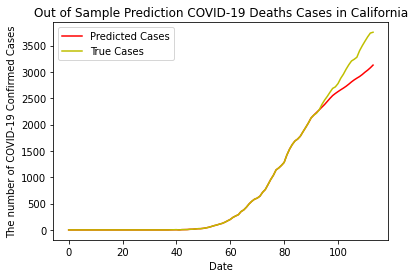

Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -370.905
Method:                       css-mle   S.D. of innovations             14.233
Date:                Sat, 06 Jun 2020   AIC                            751.810
Time:                        15:13:35   BIC                            764.364
Sample:                             1   HQIC                           756.875
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -22.4464     25.683     -0.874      0.382     -72.784      27.891
x1                 0.5020      0.490      1.02

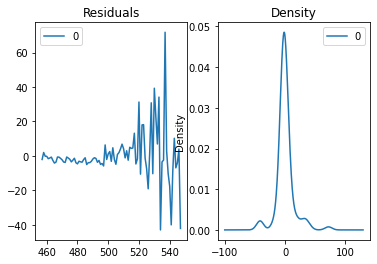

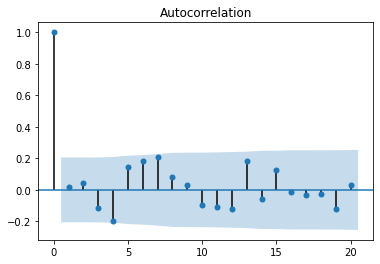

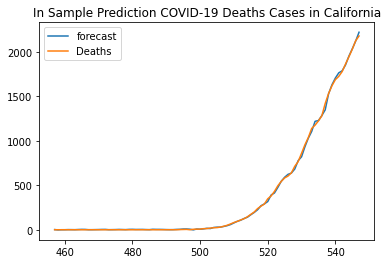

predicted=2258.000000, expected=2216.000000
predicted=2349.000000, expected=2278.000000
predicted=2451.000000, expected=2381.000000
predicted=2559.000000, expected=2464.000000
predicted=2674.000000, expected=2535.000000
predicted=2792.000000, expected=2613.000000
predicted=2913.000000, expected=2687.000000
predicted=3033.000000, expected=2716.000000
predicted=3153.000000, expected=2779.000000
predicted=3276.000000, expected=2879.000000
predicted=3402.000000, expected=2957.000000
predicted=3532.000000, expected=3052.000000
predicted=3666.000000, expected=3136.000000
predicted=3806.000000, expected=3208.000000
predicted=3945.000000, expected=3240.000000
predicted=4086.000000, expected=3279.000000
predicted=4229.000000, expected=3403.000000
predicted=4378.000000, expected=3497.000000
predicted=4533.000000, expected=3583.000000
predicted=4690.000000, expected=3666.000000
predicted=4852.000000, expected=3738.000000
predicted=5019.000000, expected=3754.000000


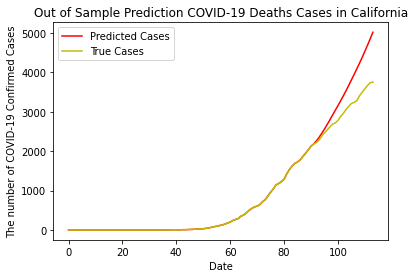

In [28]:
ARIMA_with_temp('California',3,1,0,1,1,0,1,1,0)

Results for Confirmed Cases
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -799.593
Method:                       css-mle   S.D. of innovations           1568.625
Date:                Sat, 06 Jun 2020   AIC                           1607.187
Time:                        15:13:38   BIC                           1617.230
Sample:                             1   HQIC                          1611.238
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3865.1648   2215.123      1.745      0.081    -476.396    8206.726
Avg                 -12.7864     30.314     -0.422      0.673     -72.201      46.

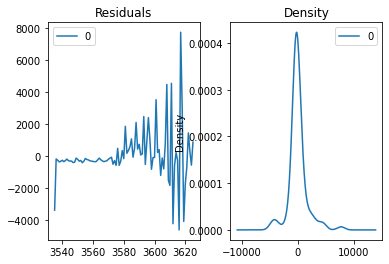

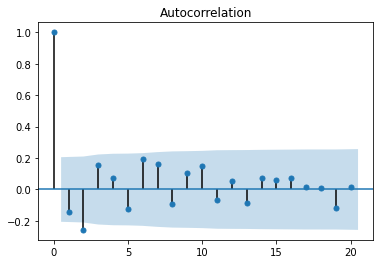

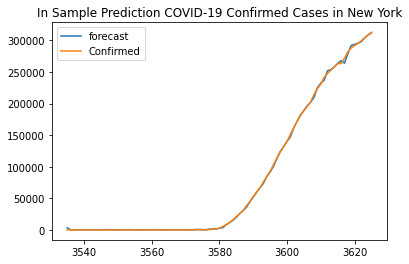

predicted=317434.000000, expected=316415.000000
predicted=321843.000000, expected=318953.000000
predicted=326234.000000, expected=321192.000000
predicted=330586.000000, expected=323978.000000
predicted=334734.000000, expected=327469.000000
predicted=338907.000000, expected=330407.000000
predicted=343095.000000, expected=333122.000000
predicted=347050.000000, expected=335395.000000
predicted=350938.000000, expected=337055.000000
predicted=354786.000000, expected=338485.000000
predicted=358575.000000, expected=340661.000000
predicted=362230.000000, expected=343051.000000
predicted=365650.000000, expected=345813.000000
predicted=369076.000000, expected=348232.000000
predicted=372591.000000, expected=350121.000000
predicted=376073.000000, expected=351371.000000
predicted=379510.000000, expected=352845.000000
predicted=382965.000000, expected=354370.000000
predicted=386405.000000, expected=356458.000000
predicted=389690.000000, expected=358154.000000
predicted=392999.000000, expected=359926

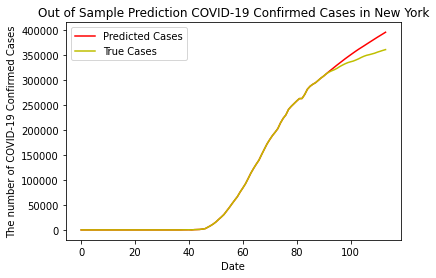

Results for Deaths Cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -664.074
Method:                       css-mle   S.D. of innovations            356.123
Date:                Sat, 06 Jun 2020   AIC                           1336.148
Time:                        15:13:39   BIC                           1346.191
Sample:                             1   HQIC                          1340.200
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            218.3230    352.591      0.619      0.536    -472.742     909.388
Avg                0.8588      7.244      0.119      0.906     -13.339      15.057
ar.L1.D.Dea

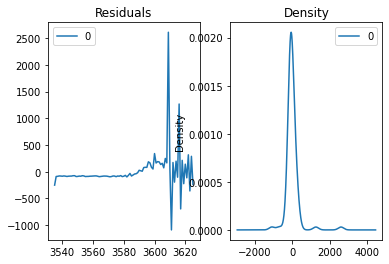

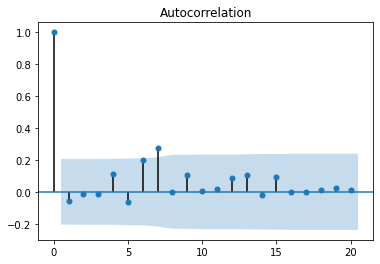

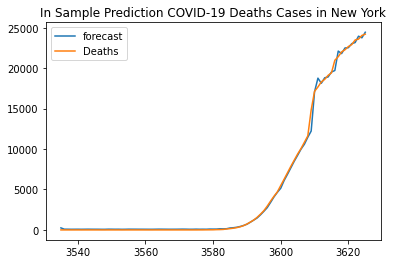

predicted=24398.000000, expected=24708.000000
predicted=24619.000000, expected=24999.000000
predicted=24850.000000, expected=25124.000000
predicted=25087.000000, expected=25623.000000
predicted=25339.000000, expected=26144.000000
predicted=25589.000000, expected=26243.000000
predicted=25836.000000, expected=26612.000000
predicted=26096.000000, expected=26641.000000
predicted=26357.000000, expected=26988.000000
predicted=26618.000000, expected=27284.000000
predicted=26879.000000, expected=27477.000000
predicted=27147.000000, expected=27641.000000
predicted=27428.000000, expected=27878.000000
predicted=27705.000000, expected=28049.000000
predicted=27975.000000, expected=28232.000000
predicted=28244.000000, expected=28339.000000
predicted=28513.000000, expected=28558.000000
predicted=28780.000000, expected=28636.000000
predicted=29046.000000, expected=28743.000000
predicted=29321.000000, expected=28853.000000
predicted=29593.000000, expected=29031.000000
predicted=29862.000000, expected=2

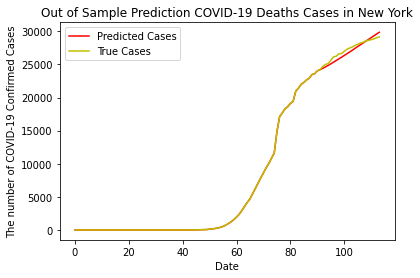

Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -659.162
Method:                       css-mle   S.D. of innovations            338.012
Date:                Sat, 06 Jun 2020   AIC                           1328.324
Time:                        15:13:40   BIC                           1340.878
Sample:                             1   HQIC                          1333.389
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            229.3805    308.284      0.744      0.457    -374.845     833.605
x1                -4.0520      6.818     -0.59

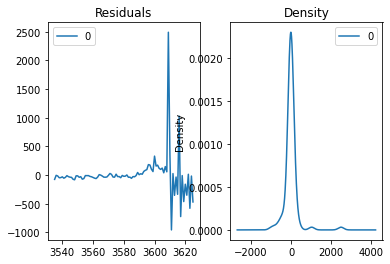

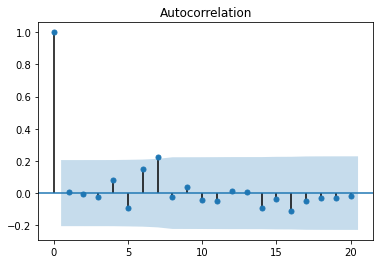

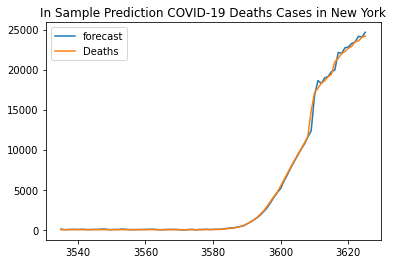

predicted=24674.000000, expected=24708.000000
predicted=25345.000000, expected=24999.000000
predicted=26133.000000, expected=25124.000000
predicted=26989.000000, expected=25623.000000
predicted=27839.000000, expected=26144.000000
predicted=28742.000000, expected=26243.000000
predicted=29688.000000, expected=26612.000000
predicted=30592.000000, expected=26641.000000
predicted=31502.000000, expected=26988.000000
predicted=32423.000000, expected=27284.000000
predicted=33349.000000, expected=27477.000000
predicted=34256.000000, expected=27641.000000
predicted=35110.000000, expected=27878.000000
predicted=35987.000000, expected=28049.000000
predicted=36909.000000, expected=28232.000000
predicted=37835.000000, expected=28339.000000
predicted=38762.000000, expected=28558.000000
predicted=39707.000000, expected=28636.000000
predicted=40662.000000, expected=28743.000000
predicted=41581.000000, expected=28853.000000
predicted=42518.000000, expected=29031.000000
predicted=43471.000000, expected=2

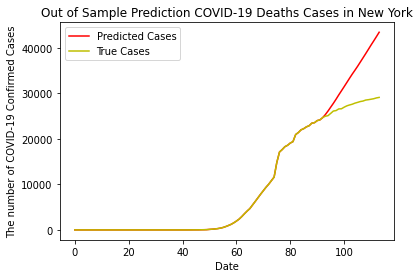

In [29]:
ARIMA_with_temp('New York',1,1,0,1,1,0,1,1,0)

Results for Confirmed Cases
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -605.066
Method:                       css-mle   S.D. of innovations            170.075
Date:                Sat, 06 Jun 2020   AIC                           1222.132
Time:                        15:13:58   BIC                           1237.197
Sample:                             1   HQIC                          1228.209
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -815.9691   2342.442     -0.348      0.728   -5407.072    3775.134
Avg                   0.8148      2.339      0.348      0.728      -3.770       5.

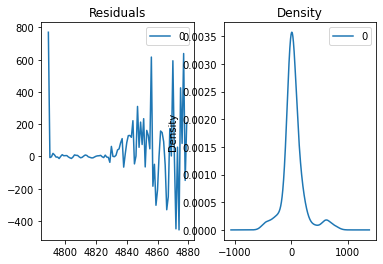

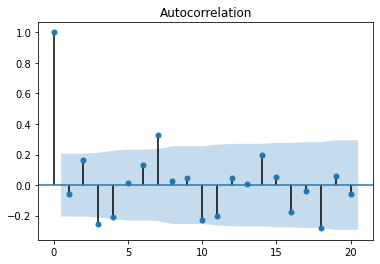

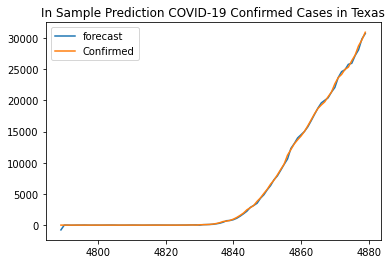

predicted=32034.000000, expected=31998.000000
predicted=33140.000000, expected=32783.000000
predicted=34243.000000, expected=33912.000000
predicted=35342.000000, expected=34928.000000
predicted=36440.000000, expected=36036.000000
predicted=37542.000000, expected=37246.000000
predicted=38638.000000, expected=38394.000000
predicted=39731.000000, expected=39258.000000
predicted=40829.000000, expected=40555.000000
predicted=41926.000000, expected=41432.000000
predicted=43026.000000, expected=43020.000000
predicted=44130.000000, expected=44480.000000
predicted=45234.000000, expected=45721.000000
predicted=46331.000000, expected=47452.000000
predicted=47433.000000, expected=48396.000000
predicted=48537.000000, expected=49177.000000
predicted=49643.000000, expected=50552.000000
predicted=50750.000000, expected=51673.000000
predicted=51856.000000, expected=53053.000000
predicted=52963.000000, expected=53539.000000
predicted=54072.000000, expected=54776.000000
predicted=55176.000000, expected=5

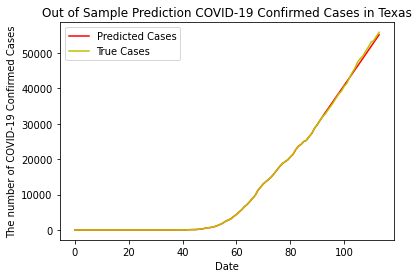

Results for Deaths Cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -312.431
Method:                       css-mle   S.D. of innovations              7.442
Date:                Sat, 06 Jun 2020   AIC                            634.862
Time:                        15:13:59   BIC                            647.416
Sample:                             1   HQIC                           639.927
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.7965      8.696      1.012      0.312      -8.248      25.841
Avg                0.0184      0.102      0.180      0.857      -0.182       0.218
ar.L1.D.Dea

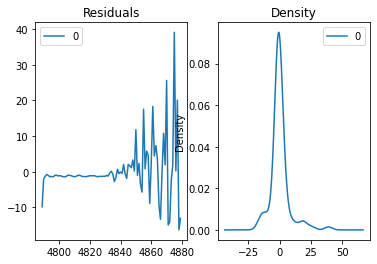

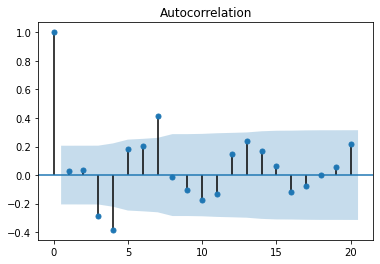

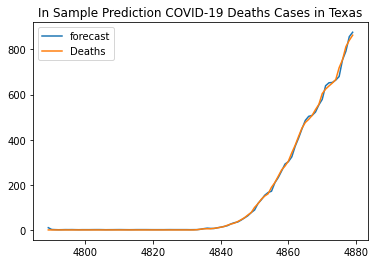

predicted=886.000000, expected=878.000000
predicted=907.000000, expected=901.000000
predicted=928.000000, expected=925.000000
predicted=948.000000, expected=954.000000
predicted=966.000000, expected=985.000000
predicted=984.000000, expected=1025.000000
predicted=1002.000000, expected=1066.000000
predicted=1018.000000, expected=1094.000000
predicted=1034.000000, expected=1117.000000
predicted=1050.000000, expected=1146.000000
predicted=1065.000000, expected=1172.000000
predicted=1079.000000, expected=1235.000000
predicted=1094.000000, expected=1280.000000
predicted=1107.000000, expected=1318.000000
predicted=1121.000000, expected=1343.000000
predicted=1134.000000, expected=1350.000000
predicted=1147.000000, expected=1388.000000
predicted=1160.000000, expected=1426.000000
predicted=1173.000000, expected=1460.000000
predicted=1185.000000, expected=1470.000000
predicted=1197.000000, expected=1478.000000
predicted=1209.000000, expected=1528.000000


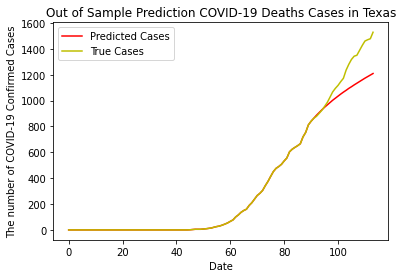

Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -304.192
Method:                       css-mle   S.D. of innovations              6.842
Date:                Sat, 06 Jun 2020   AIC                            618.383
Time:                        15:14:00   BIC                            630.937
Sample:                             1   HQIC                           623.448
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3865      6.022      0.230      0.818     -10.416      13.189
x1                 0.0047      0.098      0.04

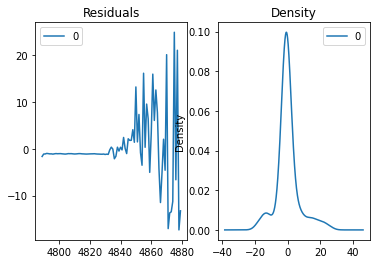

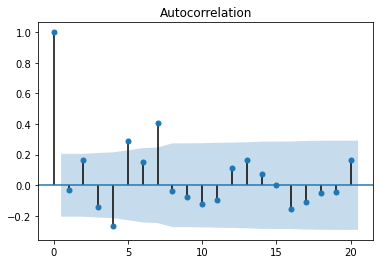

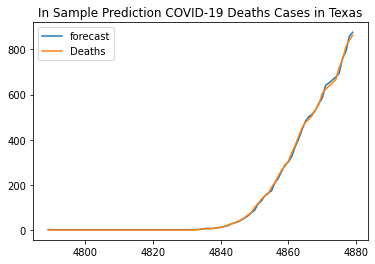

predicted=898.000000, expected=878.000000
predicted=938.000000, expected=901.000000
predicted=981.000000, expected=925.000000
predicted=1025.000000, expected=954.000000
predicted=1071.000000, expected=985.000000
predicted=1119.000000, expected=1025.000000
predicted=1168.000000, expected=1066.000000
predicted=1218.000000, expected=1094.000000
predicted=1269.000000, expected=1117.000000
predicted=1322.000000, expected=1146.000000
predicted=1376.000000, expected=1172.000000
predicted=1433.000000, expected=1235.000000
predicted=1491.000000, expected=1280.000000
predicted=1551.000000, expected=1318.000000
predicted=1612.000000, expected=1343.000000
predicted=1674.000000, expected=1350.000000
predicted=1738.000000, expected=1388.000000
predicted=1803.000000, expected=1426.000000
predicted=1870.000000, expected=1460.000000
predicted=1938.000000, expected=1470.000000
predicted=2007.000000, expected=1478.000000
predicted=2078.000000, expected=1528.000000


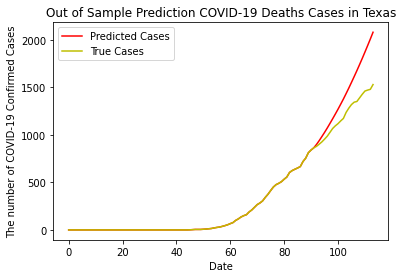

In [30]:
ARIMA_with_temp('Texas',2,1,1,2,1,0,1,1,0)

Results for Confirmed Cases
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -582.090
Method:                       css-mle   S.D. of innovations            144.186
Date:                Sat, 06 Jun 2020   AIC                           1176.179
Time:                        15:14:02   BIC                           1191.245
Sample:                             1   HQIC                          1182.257
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -38.0185    219.109     -0.174      0.862    -467.465     391.428
Avg                   4.2347      4.317      0.981      0.327      -4.226      12.

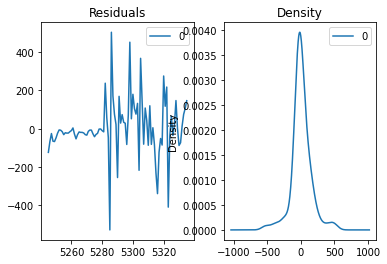

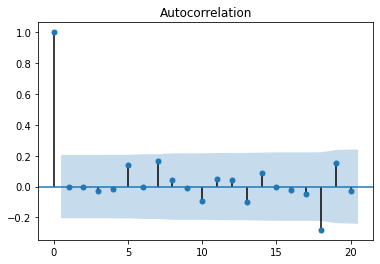

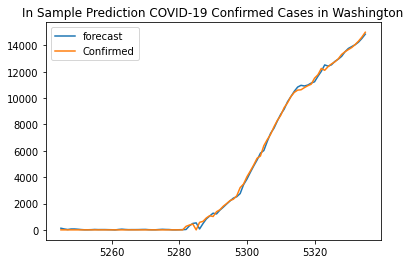

predicted=15233.000000, expected=15185.000000
predicted=15521.000000, expected=15462.000000
predicted=15813.000000, expected=15594.000000
predicted=16085.000000, expected=15905.000000
predicted=16361.000000, expected=16231.000000
predicted=16681.000000, expected=16388.000000
predicted=17028.000000, expected=16674.000000
predicted=17382.000000, expected=16891.000000
predicted=17666.000000, expected=17122.000000
predicted=17926.000000, expected=17330.000000
predicted=18184.000000, expected=17512.000000
predicted=18439.000000, expected=17773.000000
predicted=18702.000000, expected=17951.000000
predicted=18958.000000, expected=18288.000000
predicted=19213.000000, expected=18433.000000
predicted=19469.000000, expected=18611.000000
predicted=19713.000000, expected=18811.000000
predicted=19945.000000, expected=18971.000000
predicted=20163.000000, expected=19117.000000
predicted=20387.000000, expected=19265.000000
predicted=20618.000000, expected=19265.000000
predicted=20869.000000, expected=1

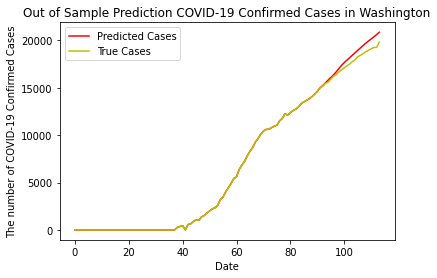

Results for Deaths Cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -329.088
Method:                       css-mle   S.D. of innovations              8.980
Date:                Sat, 06 Jun 2020   AIC                            668.177
Time:                        15:14:03   BIC                            680.731
Sample:                             1   HQIC                           673.242
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -25.6109     13.343     -1.919      0.055     -51.762       0.541
Avg                0.7408      0.284      2.611      0.009       0.185       1.297
ar.L1.D.Dea

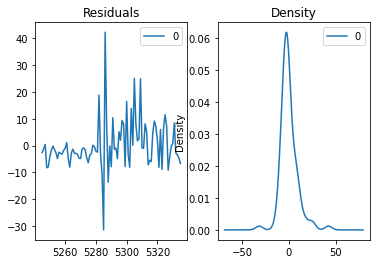

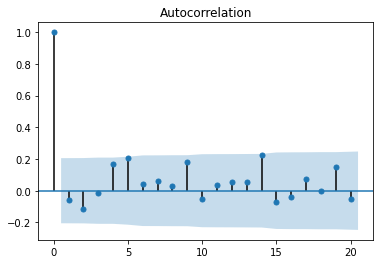

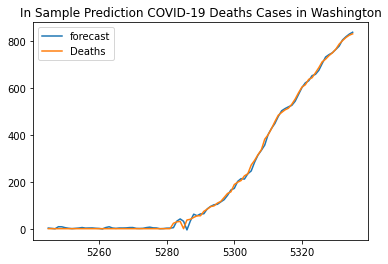

predicted=837.000000, expected=834.000000
predicted=847.000000, expected=841.000000
predicted=863.000000, expected=862.000000
predicted=876.000000, expected=870.000000
predicted=890.000000, expected=891.000000
predicted=913.000000, expected=905.000000
predicted=942.000000, expected=921.000000
predicted=973.000000, expected=931.000000
predicted=992.000000, expected=945.000000
predicted=1008.000000, expected=962.000000
predicted=1024.000000, expected=974.000000
predicted=1040.000000, expected=983.000000
predicted=1057.000000, expected=991.000000
predicted=1074.000000, expected=999.000000
predicted=1091.000000, expected=1001.000000
predicted=1109.000000, expected=1002.000000
predicted=1125.000000, expected=1031.000000
predicted=1139.000000, expected=1037.000000
predicted=1151.000000, expected=1044.000000
predicted=1164.000000, expected=1050.000000
predicted=1179.000000, expected=1050.000000
predicted=1198.000000, expected=1061.000000


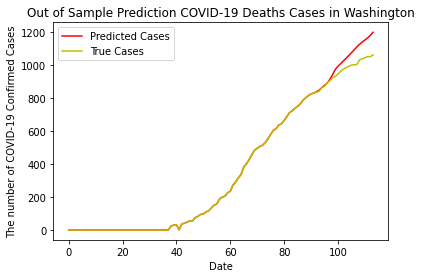

Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -331.225
Method:                       css-mle   S.D. of innovations              9.215
Date:                Sat, 06 Jun 2020   AIC                            672.450
Time:                        15:14:04   BIC                            685.005
Sample:                             1   HQIC                           677.515
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4329     15.198      0.028      0.977     -29.355      30.220
x1                 0.0666      0.352      0.19

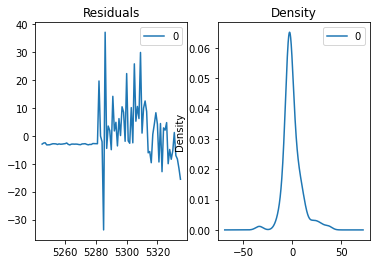

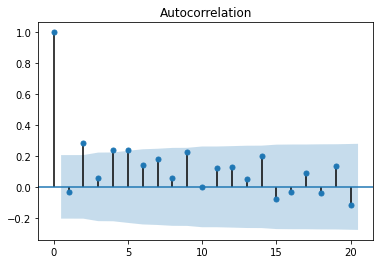

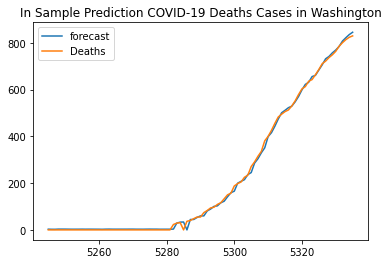

predicted=851.000000, expected=834.000000
predicted=874.000000, expected=841.000000
predicted=898.000000, expected=862.000000
predicted=922.000000, expected=870.000000
predicted=947.000000, expected=891.000000
predicted=972.000000, expected=905.000000
predicted=999.000000, expected=921.000000
predicted=1026.000000, expected=931.000000
predicted=1052.000000, expected=945.000000
predicted=1078.000000, expected=962.000000
predicted=1105.000000, expected=974.000000
predicted=1131.000000, expected=983.000000
predicted=1158.000000, expected=991.000000
predicted=1186.000000, expected=999.000000
predicted=1213.000000, expected=1001.000000
predicted=1241.000000, expected=1002.000000
predicted=1269.000000, expected=1031.000000
predicted=1297.000000, expected=1037.000000
predicted=1325.000000, expected=1044.000000
predicted=1354.000000, expected=1050.000000
predicted=1382.000000, expected=1050.000000
predicted=1412.000000, expected=1061.000000


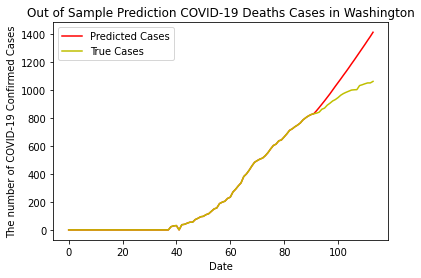

In [31]:
ARIMA_with_temp('Washington',2,1,1,2,1,0,1,1,0)

Results for Confirmed Cases
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -633.721
Method:                       css-mle   S.D. of innovations            253.303
Date:                Sat, 06 Jun 2020   AIC                           1279.442
Time:                        15:14:06   BIC                           1294.508
Sample:                             1   HQIC                          1285.520
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               507.6308    348.436      1.457      0.145    -175.291    1190.553
Avg                  -1.8097      3.290     -0.550      0.582      -8.257       4.

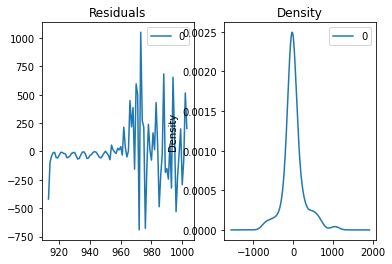

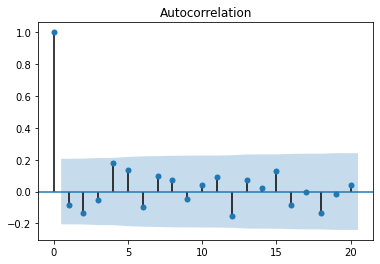

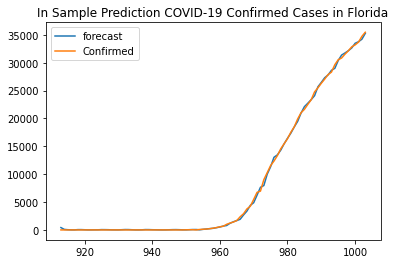

predicted=36181.000000, expected=36078.000000
predicted=36999.000000, expected=36897.000000
predicted=37712.000000, expected=37439.000000
predicted=38432.000000, expected=38002.000000
predicted=39178.000000, expected=38828.000000
predicted=39886.000000, expected=39199.000000
predicted=40585.000000, expected=40001.000000
predicted=41272.000000, expected=40596.000000
predicted=41943.000000, expected=40982.000000
predicted=42609.000000, expected=41923.000000
predicted=43257.000000, expected=42402.000000
predicted=43891.000000, expected=43210.000000
predicted=44514.000000, expected=44138.000000
predicted=45125.000000, expected=44811.000000
predicted=45726.000000, expected=45588.000000
predicted=46327.000000, expected=46442.000000
predicted=46914.000000, expected=46944.000000
predicted=47506.000000, expected=47471.000000
predicted=48084.000000, expected=48675.000000
predicted=48651.000000, expected=49451.000000
predicted=49211.000000, expected=50127.000000
predicted=49761.000000, expected=5

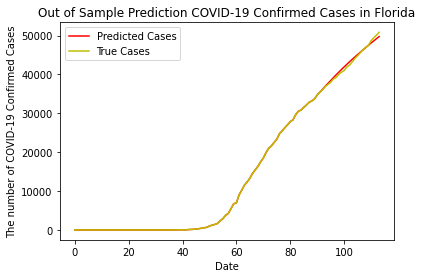

Results for Deaths Cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -382.709
Method:                       css-mle   S.D. of innovations             14.721
Date:                Sat, 06 Jun 2020   AIC                            779.417
Time:                        15:14:08   BIC                            796.993
Sample:                             1   HQIC                           786.508
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -43.3693     62.013     -0.699      0.484    -164.913      78.174
Avg               -0.1502      0.215     -0.699      0.484      -0.571       0.271
ar.L1.D.Dea

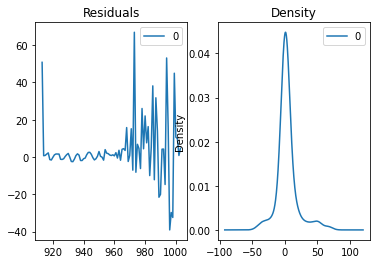

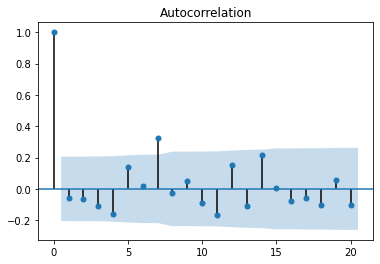

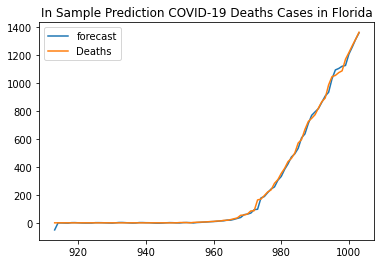

predicted=1409.000000, expected=1379.000000
predicted=1456.000000, expected=1399.000000
predicted=1502.000000, expected=1471.000000
predicted=1547.000000, expected=1539.000000
predicted=1595.000000, expected=1600.000000
predicted=1642.000000, expected=1669.000000
predicted=1689.000000, expected=1715.000000
predicted=1735.000000, expected=1721.000000
predicted=1781.000000, expected=1735.000000
predicted=1827.000000, expected=1779.000000
predicted=1873.000000, expected=1827.000000
predicted=1919.000000, expected=1875.000000
predicted=1964.000000, expected=1917.000000
predicted=2009.000000, expected=1964.000000
predicted=2054.000000, expected=1973.000000
predicted=2099.000000, expected=1997.000000
predicted=2145.000000, expected=2052.000000
predicted=2191.000000, expected=2096.000000
predicted=2236.000000, expected=2144.000000
predicted=2281.000000, expected=2190.000000
predicted=2327.000000, expected=2233.000000
predicted=2372.000000, expected=2237.000000


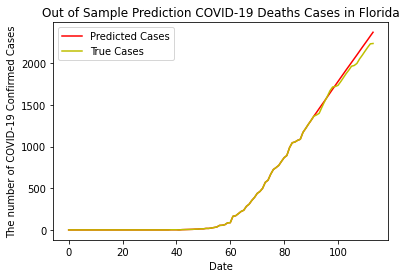

Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -367.264
Method:                       css-mle   S.D. of innovations             13.693
Date:                Sat, 06 Jun 2020   AIC                            744.528
Time:                        15:14:09   BIC                            757.082
Sample:                             1   HQIC                           749.592
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9904     11.424     -0.262      0.794     -25.382      19.401
x1                 0.0765      0.180      0.42

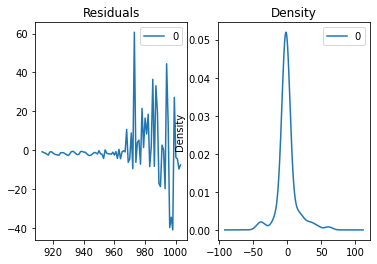

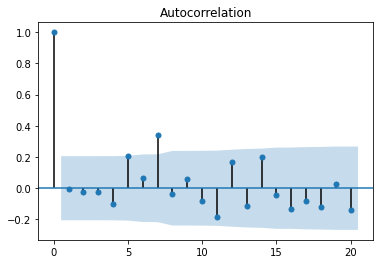

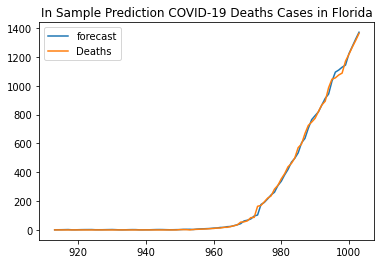

predicted=1422.000000, expected=1379.000000
predicted=1481.000000, expected=1399.000000
predicted=1541.000000, expected=1471.000000
predicted=1602.000000, expected=1539.000000
predicted=1663.000000, expected=1600.000000
predicted=1725.000000, expected=1669.000000
predicted=1789.000000, expected=1715.000000
predicted=1854.000000, expected=1721.000000
predicted=1919.000000, expected=1735.000000
predicted=1986.000000, expected=1779.000000
predicted=2054.000000, expected=1827.000000
predicted=2123.000000, expected=1875.000000
predicted=2193.000000, expected=1917.000000
predicted=2265.000000, expected=1964.000000
predicted=2338.000000, expected=1973.000000
predicted=2412.000000, expected=1997.000000
predicted=2487.000000, expected=2052.000000
predicted=2563.000000, expected=2096.000000
predicted=2640.000000, expected=2144.000000
predicted=2719.000000, expected=2190.000000
predicted=2799.000000, expected=2233.000000
predicted=2880.000000, expected=2237.000000


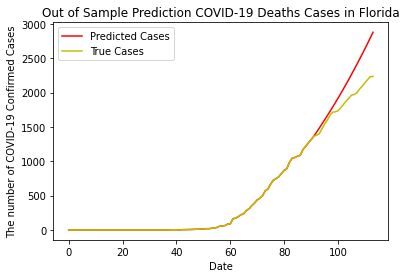

In [32]:
ARIMA_with_temp('Florida',3,1,0,3,1,1,1,1,0)

1. When we are predicting death cases, it is not good to use confirmed cases as a feature. Temperature is enough.

2. Only in some states, the temperature is a significant factor for predicting death cases.